This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

* This notebook is to present how our logistic regression model works on the cerner sample data for predicting heart failure onset risk using pytorch library
* For this demonstration, the data is the original 1 hospital (h143) previously used by retain, with 42,729 patients in total
* The logistic regression model has the architecture of an embedding layer (embedding dimension =2), a linear activation and sigmoid transformation. The hyperparameters used are bayesian optimized already (lr = np.exp(-7.8810), L2 = np.exp(-5.8401))
* Our model achieves overall 0.8102 test auc (visits < 5: 0.8138 test auc, visits >= 5:0.8136 test auc), with corresponding 0.7801 validation auc on epoch 9
* Since the embedding dimension =2, we plot the embedded matrix colored by predicted labels vs embedded matrix colored by real labels to demonstrate how the classifications evolves with epoches
* Visualization of training loss, training auc, validation auc, and test auc for each epoch as well as how average loss, training auc, validation auc and test auc change with epochs are shown at the end
* Since github does not render Plotly graph, we upload a static one, and if you're curious about the original interactive plot, you can also click on the link provided

In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random
import pandas as pd
import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchviz import make_dot, make_dot_from_trace

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle
    
import operator
from functools import reduce 

In [2]:
# import self-defined modules
# import ehr_pytorch.model as model 
# import ehr.pytorch.Loaddata as Loaddata
# import ehr.pytorch.TrainVeTe as TVT 

import model_em as model #here the em experiment
import Loaddata as Loaddata
import TrainVaTe_em as TVT

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda
torch.cuda.set_device(0)

In [3]:
parser = argparse.ArgumentParser(description='30 Hospital Readmission Model with Pytorch: LR, RNN, CNN')
# learning
parser.add_argument('-lr', type=float, default=np.exp(-7.8810), help='initial learning rate [default: 0.0004]')
parser.add_argument('-L2', type=float, default=np.exp(-5.8401), help='L2 regularization [default: 0.003]')
parser.add_argument('-epochs', type=int, default=20, help='number of epochs for train [default: 20]')
parser.add_argument('-batch_size', type=int, default=1, help='batch size for training [default: 1]')
#parser.add_argument('-save-dir', type=str, default='snapshot', help='where to save the snapshot')
#parser.add_argument('-save-best', type=bool, default=True, help='whether to save when get best performance')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
parser.add_argument('-validation_ratio', type = float, default = 0.1, help='validation data size [default: 0.1]')
parser.add_argument('-test_ratio', type = float, default = 0.2, help='test data size [default: 0.2]')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "RNN", "CNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension [default: 20000]')
parser.add_argument('-embed_dim', type=int, default=128, help='number of embedding dimension [default: 128]')
parser.add_argument('-ch_out', type=int, default=64, help='number of each kind of kernel [default; 64]')
parser.add_argument('-kernel_sizes', type=list, default=[3], help='comma-separated kernel size to use for convolution [default:[3]')
parser.add_argument('-dropout', type=float, default=0.1, help='the probability for dropout [default: 0.1]')
parser.add_argument('-eb_mode', type=str, default='sum', help= "embedding mode [default: 'sum']")

_StoreAction(option_strings=['-eb_mode'], dest='eb_mode', nargs=None, const=None, default='sum', type=<class 'str'>, choices=None, help="embedding mode [default: 'sum']", metavar=None)

In [4]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.lr = np.exp(-7.8810)
args.L2 = np.exp(-5.8401)
args.epochs = 20
args.batch_size = 1
#args.seq_file = 'data/cerner/hospital_data/h143.visits'
#args.label_file = 'data/cerner/hospital_data/h143.labels'
args.seq_file = 'Data/h143.visits'
args.label_file = 'Data/h143.labels'
args.which_model = 'LR'
args.input_size = 20000

In [5]:
# load and prepare data
set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
"""
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit]) 
"""
model_x = set_x     

merged_set= [[set_y[i],model_x[i]] for i in range(len(set_y))] #list of list or list of lists of lists
print("\nLoading and preparing data...")    
train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])
print("model is", args.which_model)

#further processing training, valid, test data format, for the visits information merged into one huge list 

#split the test data according to length
test_sh_L =[x for x in test1 if len(x[1])< 5]
test_l_L = [x for x in test1 if x not in test_sh_L]
print(test_sh_L[0])
print(test_l_L[0])

train1 = [[train1[i][0],reduce(operator.concat, train1[i][1])] for i in range(len(train1))]
valid1 = [[valid1[i][0],reduce(operator.concat, valid1[i][1])] for i in range(len(valid1))]
test1 = [[test1[i][0],reduce(operator.concat, test1[i][1])] for i in range(len(test1))]
test_sh_L = [[test_sh_L[i][0],reduce(operator.concat, test_sh_L[i][1])] for i in range(len(test_sh_L))]
test_l_L = [[test_l_L[i][0],reduce(operator.concat, test_l_L[i][1])] for i in range(len(test_l_L))]
print('-' * 120)
print('\nAfter flatten:')
print(train1[4])
print(test_sh_L[0])
print(test_l_L[0])


Loading and preparing data...

Sample data after split:
[0, [[1667, 144, 62, 85], [1667, 144, 62, 85]]]
model is LR
[0, [[1027, 379, 62, 85], [4547, 3142, 379, 62, 85], [1027, 379, 62, 85]]]
[1, [[673, 124, 449, 267, 84, 63], [1677, 124, 449, 267, 84, 63], [793, 124, 449, 267, 84, 63], [9565, 124, 449, 3565, 267, 84, 63], [148, 673, 124, 449, 267, 84, 63], [2399, 148, 124, 449, 3565, 267, 84, 63], [115, 246, 124, 414, 129, 5148, 1442, 420, 6757, 156, 15, 185, 186, 93, 259, 960, 221, 1259, 2413, 6, 26, 111, 29, 213, 80, 214, 570, 31, 370, 8, 192, 35, 10, 40, 553, 43, 44, 49, 959, 82, 880, 267, 84, 63], [358, 559, 124, 449, 267, 84, 63], [717, 396, 370, 8, 267, 84, 63], [433, 146, 513, 321, 246, 449, 129, 1442, 156, 16, 89, 954, 3067, 960, 1259, 135, 26, 262, 855, 956, 80, 214, 190, 32, 139, 37, 880, 267, 84, 63], [673, 124, 129, 277, 267, 84, 63], [150, 113, 7525, 4535, 267, 84, 63], [556, 9566, 132, 267, 84, 63], [124, 129, 132, 267, 84, 63], [346, 5594, 267, 84, 63], [268, 793, 449, 

Parameter containing:
-2.1174e-01 -2.5768e-02
-4.5049e-01 -1.1866e+00
-1.6846e-01 -5.1947e-02
           ⋮            
 4.6902e-01 -5.4585e-01
-4.7878e-02 -1.1050e+00
 2.7606e+00 -8.6309e-01
[torch.FloatTensor of size 20000x2]

15815
      emb_0     emb_1                           types
0 -0.211736 -0.025768                            Code
1 -0.450486 -1.186551  b'M_ACETAMINOPHEN-HYDROCODONE'
2 -0.168455 -0.051947         b'M_BACITRACIN TOPICAL'
3  0.939073  0.789640    b'M_BUPIVACAINE-EPINEPHRINE'
4 -0.524550  0.104543                  b'M_CEFAZOLIN'


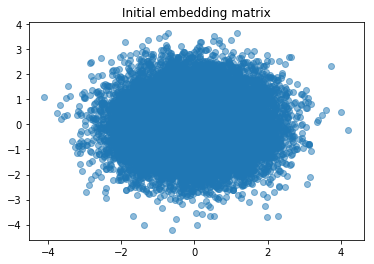

In [6]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model.EHR_LR(args.input_size)
elif args.which_model == 'RNN':
    ehr_model = model.EHR_RNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode) 
else: 
    ehr_model = model.EHR_CNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode, args.ch_out, args.kernel_sizes)    
if use_cuda:
    ehr_model = ehr_model.cuda()

optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=args.L2)

In [7]:
## train validation and test part
current_loss_allep=[]
all_losses_allep=[]
avg_losses_allep=[]
train_auc_allep =[]
valid_auc_allep =[]
test_auc_allep = []
test_sh_auc_allep=[]
test_l_auc_allep=[]

In [8]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


 Current running on: Epoch  0 Training loss:  Average loss 0.808306205052124


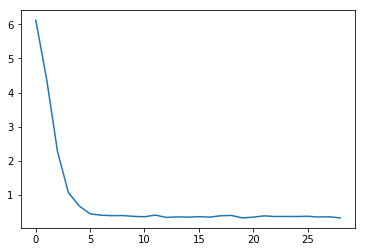

Epoch  0 Summary:  Training_auc : 0.6405443918700101  , Validation_auc :  0.6181386458676554  ,Test_auc :  0.6185153039954291 Test_auc on short visits: 0.6411574929618967 Test_auc on long visits: 0.6040661552720172  Avg Loss:  0.808306205052124 Train Time (1m 7s) Eval Time (0m 37s)


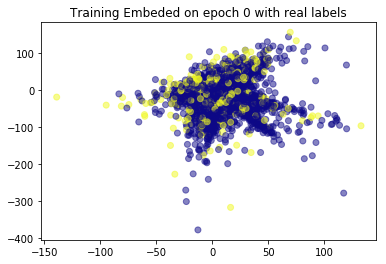

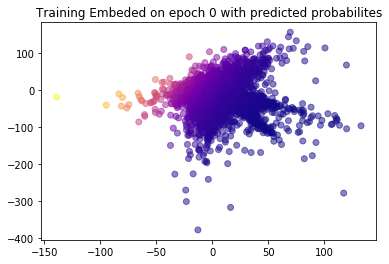


 Current running on: Epoch  1 Training loss:  Average loss 0.34867041932169707


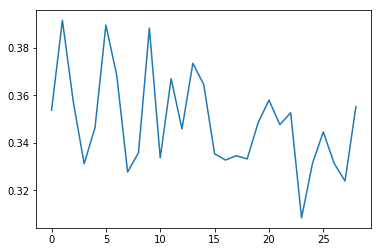

Epoch  1 Summary:  Training_auc : 0.7618237154213289  , Validation_auc :  0.7474841360000918  ,Test_auc :  0.7635049930966064 Test_auc on short visits: 0.7884158866556507 Test_auc on long visits: 0.7606475681279512  Avg Loss:  0.34867041932169707 Train Time (0m 59s) Eval Time (0m 39s)


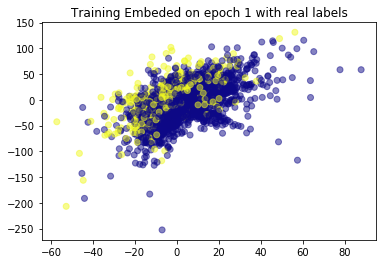

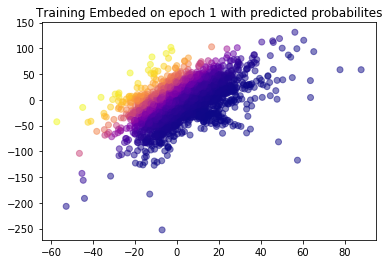


 Current running on: Epoch  2 Training loss:  Average loss 0.3344104976488899


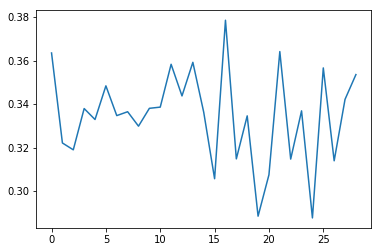

Epoch  2 Summary:  Training_auc : 0.780289717873519  , Validation_auc :  0.7657840856746154  ,Test_auc :  0.7922577564256493 Test_auc on short visits: 0.8051484360908515 Test_auc on long visits: 0.7944960967693486  Avg Loss:  0.3344104976488899 Train Time (1m 2s) Eval Time (0m 38s)


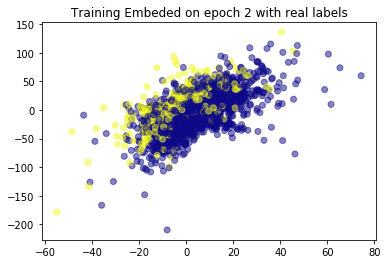

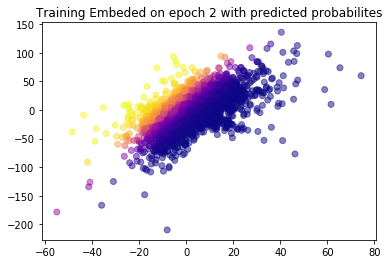


 Current running on: Epoch  3 Training loss:  Average loss 0.3294487707787935


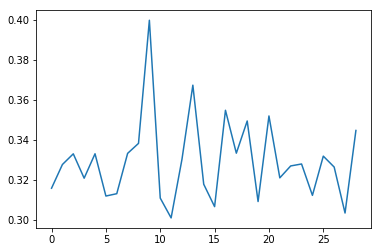

Epoch  3 Summary:  Training_auc : 0.7891025266486172  , Validation_auc :  0.7727659941849759  ,Test_auc :  0.8022652975366702 Test_auc on short visits: 0.812105273242258 Test_auc on long visits: 0.8018467079885265  Avg Loss:  0.3294487707787935 Train Time (0m 59s) Eval Time (0m 37s)


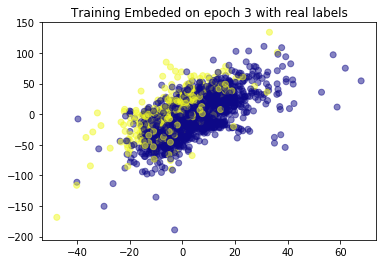

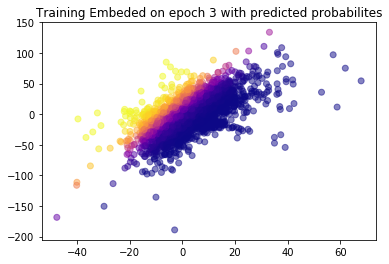


 Current running on: Epoch  4 Training loss:  Average loss 0.32761718852189664


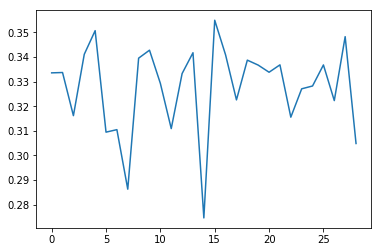

Epoch  4 Summary:  Training_auc : 0.7842605011915247  , Validation_auc :  0.7554684558712237  ,Test_auc :  0.7914703997115178 Test_auc on short visits: 0.8124501584688153 Test_auc on long visits: 0.7851707457350199  Avg Loss:  0.32761718852189664 Train Time (0m 58s) Eval Time (1m 4s)


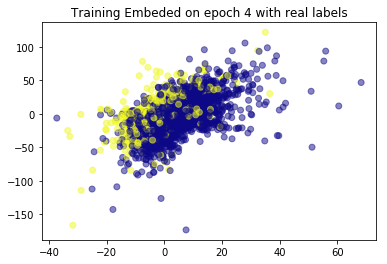

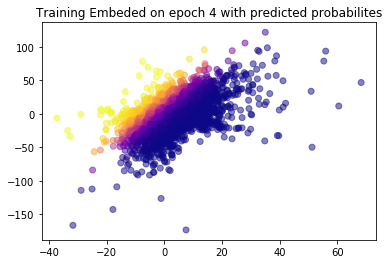


 Current running on: Epoch  5 Training loss:  Average loss 0.3269257874236123


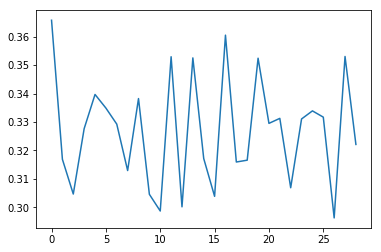

Epoch  5 Summary:  Training_auc : 0.77797030355839  , Validation_auc :  0.7581560330191952  ,Test_auc :  0.78785553428622 Test_auc on short visits: 0.8084357472876627 Test_auc on long visits: 0.7834059579674628  Avg Loss:  0.3269257874236123 Train Time (1m 48s) Eval Time (0m 53s)


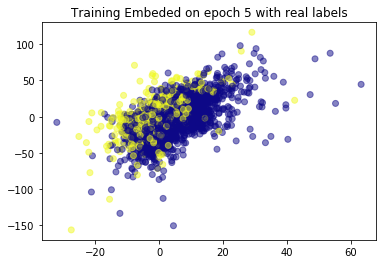

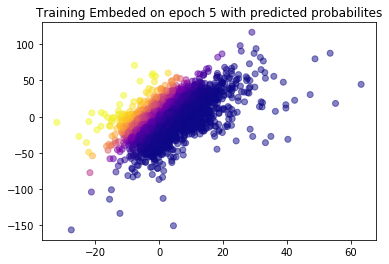


 Current running on: Epoch  6 Training loss:  Average loss 0.3252510051015357


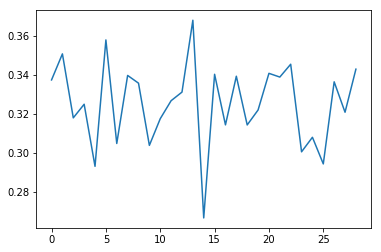

Epoch  6 Summary:  Training_auc : 0.785163710233216  , Validation_auc :  0.7598690663340049  ,Test_auc :  0.7947167759398037 Test_auc on short visits: 0.8104634345679386 Test_auc on long visits: 0.7924982324647684  Avg Loss:  0.3252510051015357 Train Time (0m 53s) Eval Time (0m 34s)


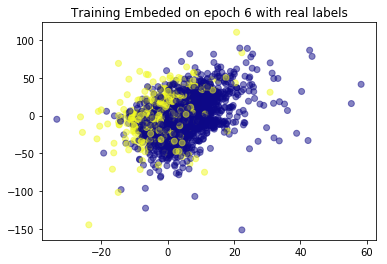

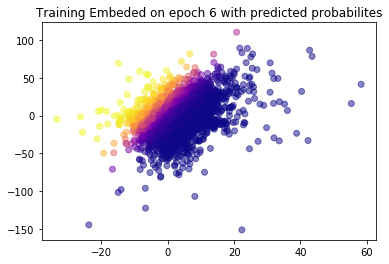


 Current running on: Epoch  7 Training loss:  Average loss 0.3251854840565151


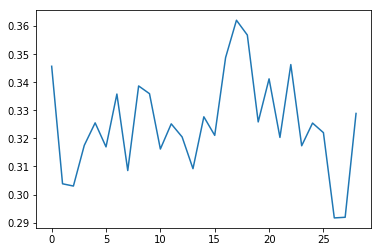

Epoch  7 Summary:  Training_auc : 0.7882816835964634  , Validation_auc :  0.769238019831844  ,Test_auc :  0.7971097121514683 Test_auc on short visits: 0.8167860000383205 Test_auc on long visits: 0.7926997131647491  Avg Loss:  0.3251854840565151 Train Time (0m 55s) Eval Time (0m 34s)


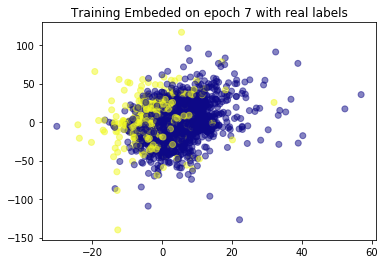

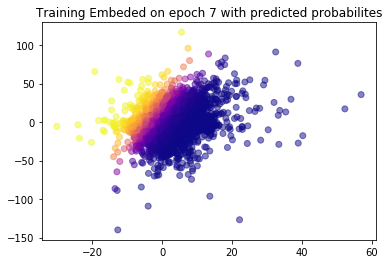


 Current running on: Epoch  8 Training loss:  Average loss 0.32361435329639787


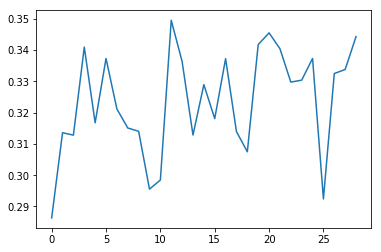

Epoch  8 Summary:  Training_auc : 0.7964919493340386  , Validation_auc :  0.7725911391097801  ,Test_auc :  0.809395563498847 Test_auc on short visits: 0.8090779473647003 Test_auc on long visits: 0.8125240403107931  Avg Loss:  0.32361435329639787 Train Time (1m 4s) Eval Time (1m 6s)


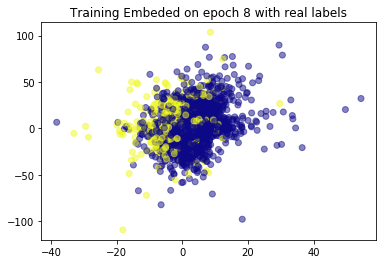

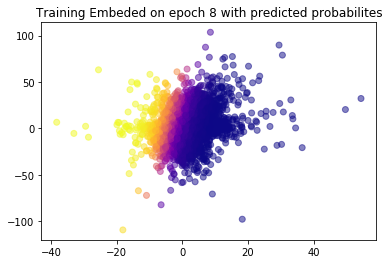


 Current running on: Epoch  9 Training loss:  Average loss 0.3242871829686185


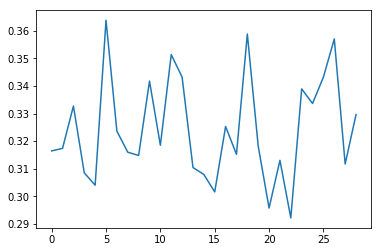

Epoch  9 Summary:  Training_auc : 0.8003838076925769  , Validation_auc :  0.7801006181673331  ,Test_auc :  0.8101615723148491 Test_auc on short visits: 0.8138032713883347 Test_auc on long visits: 0.8135740295041011  Avg Loss:  0.3242871829686185 Train Time (1m 27s) Eval Time (0m 33s)


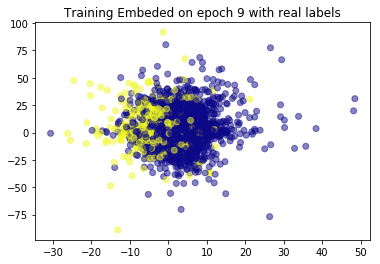

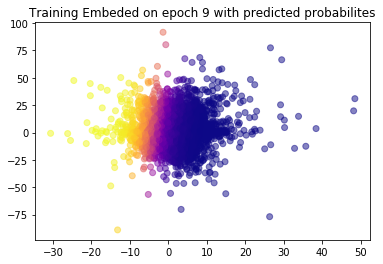


 Current running on: Epoch  10 Training loss:  Average loss 0.3225678049334198


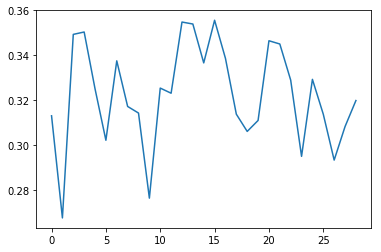

Epoch  10 Summary:  Training_auc : 0.7923701234682134  , Validation_auc :  0.7656608674888133  ,Test_auc :  0.7981614020755595 Test_auc on short visits: 0.8156733817978564 Test_auc on long visits: 0.7941329735987017  Avg Loss:  0.3225678049334198 Train Time (0m 48s) Eval Time (0m 32s)


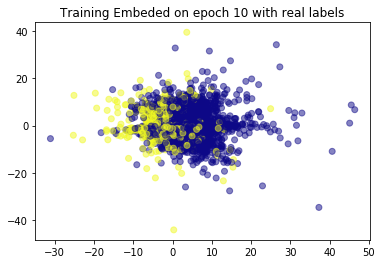

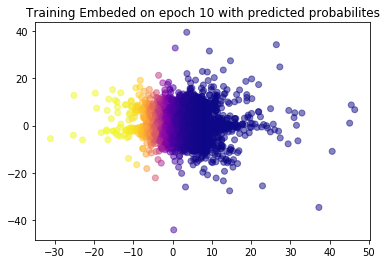


 Current running on: Epoch  11 Training loss:  Average loss 0.3249228721479164


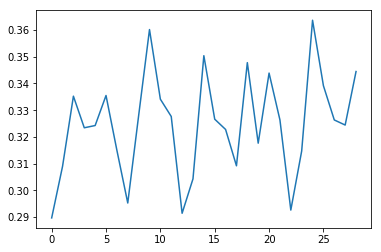

Epoch  11 Summary:  Training_auc : 0.7960181114909961  , Validation_auc :  0.7734796214606191  ,Test_auc :  0.8047519877340689 Test_auc on short visits: 0.8159201531237549 Test_auc on long visits: 0.8033241568032705  Avg Loss:  0.3249228721479164 Train Time (0m 47s) Eval Time (0m 32s)


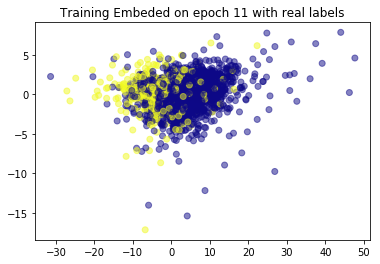

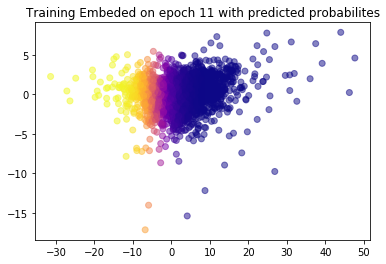


 Current running on: Epoch  12 Training loss:  Average loss 0.32393728217117485


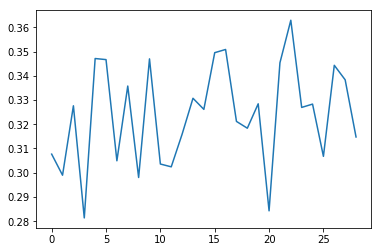

Epoch  12 Summary:  Training_auc : 0.7979439519900657  , Validation_auc :  0.7752475701974825  ,Test_auc :  0.8090542010895858 Test_auc on short visits: 0.8182871096834127 Test_auc on long visits: 0.8099620300462673  Avg Loss:  0.32393728217117485 Train Time (0m 53s) Eval Time (0m 28s)


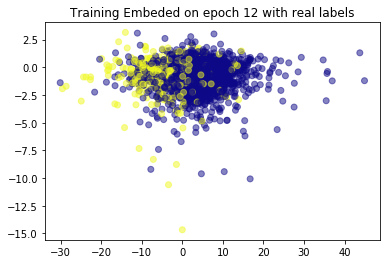

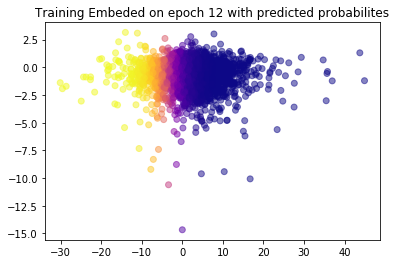


 Current running on: Epoch  13 Training loss:  Average loss 0.32389459406959675


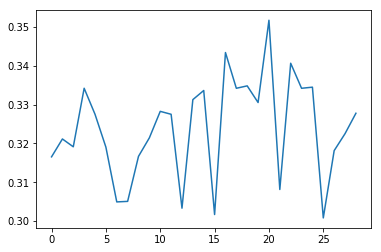

Epoch  13 Summary:  Training_auc : 0.7952723949279068  , Validation_auc :  0.7661714989505963  ,Test_auc :  0.8057309316358717 Test_auc on short visits: 0.8115238575346521 Test_auc on long visits: 0.8071426739785844  Avg Loss:  0.32389459406959675 Train Time (0m 47s) Eval Time (0m 27s)


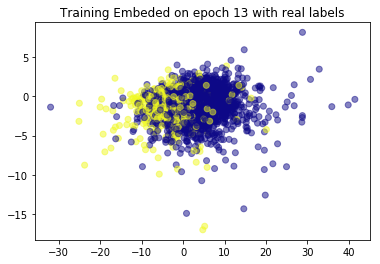

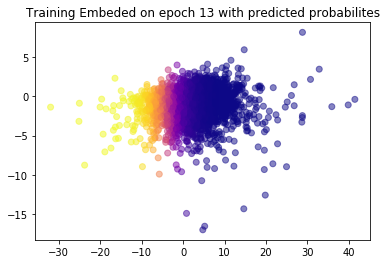


 Current running on: Epoch  14 Training loss:  Average loss 0.3231313633080499


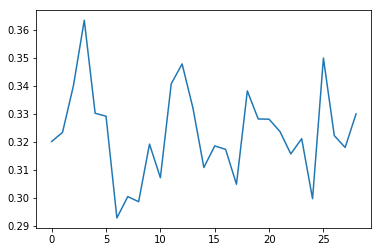

Epoch  14 Summary:  Training_auc : 0.7911178606041599  , Validation_auc :  0.7638934651740602  ,Test_auc :  0.8035671793878837 Test_auc on short visits: 0.8090065918005849 Test_auc on long visits: 0.8054062766732973  Avg Loss:  0.3231313633080499 Train Time (0m 45s) Eval Time (0m 27s)


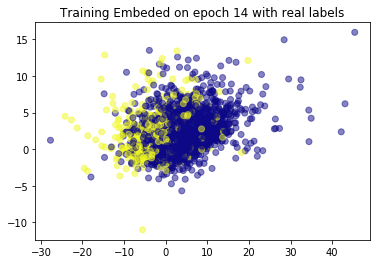

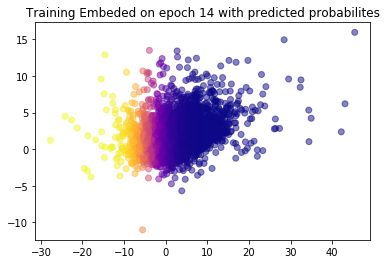


 Current running on: Epoch  15 Training loss:  Average loss 0.32284025351282086


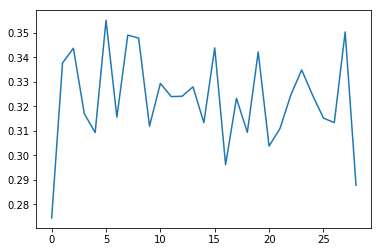

Epoch  15 Summary:  Training_auc : 0.7966089016769777  , Validation_auc :  0.7696705129318989  ,Test_auc :  0.8028961483224768 Test_auc on short visits: 0.8152911670400721 Test_auc on long visits: 0.8018982229402262  Avg Loss:  0.32284025351282086 Train Time (0m 48s) Eval Time (1m 1s)


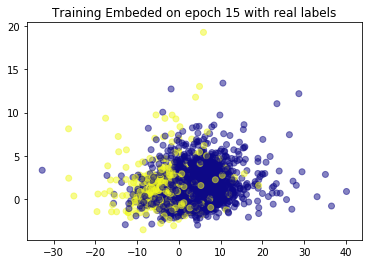

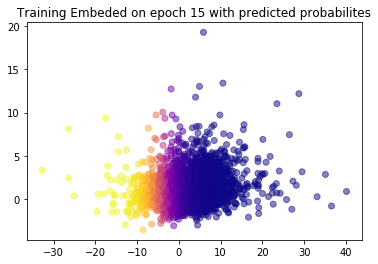


 Current running on: Epoch  16 Training loss:  Average loss 0.3231386748498288


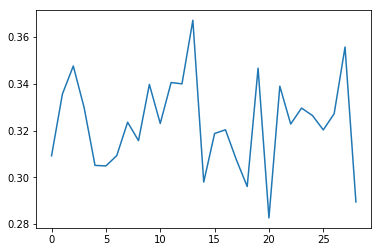

Epoch  16 Summary:  Training_auc : 0.7928812738140621  , Validation_auc :  0.7544969173596665  ,Test_auc :  0.8003025826605572 Test_auc on short visits: 0.8176174905701641 Test_auc on long visits: 0.7958556335835357  Avg Loss:  0.3231386748498288 Train Time (1m 15s) Eval Time (0m 27s)


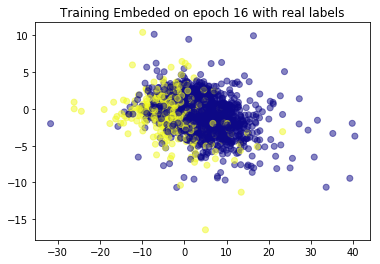

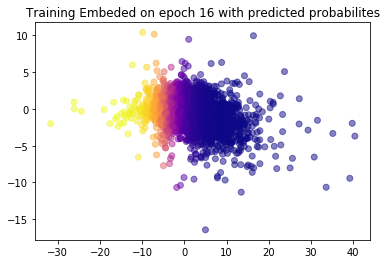


 Current running on: Epoch  17 Training loss:  Average loss 0.3236083570603773


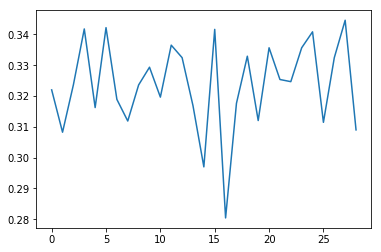

Epoch  17 Summary:  Training_auc : 0.7974266344647425  , Validation_auc :  0.7687899537016547  ,Test_auc :  0.8034152285843188 Test_auc on short visits: 0.8129631917608109 Test_auc on long visits: 0.8033960487803091  Avg Loss:  0.3236083570603773 Train Time (0m 39s) Eval Time (0m 29s)


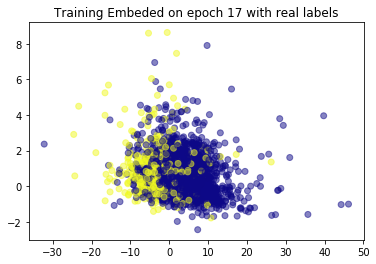

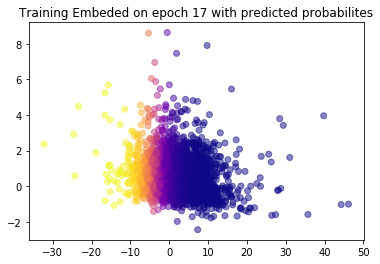


 Current running on: Epoch  18 Training loss:  Average loss 0.32402854353053673


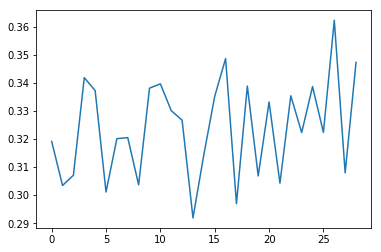

Epoch  18 Summary:  Training_auc : 0.7938382802933135  , Validation_auc :  0.7660430897547494  ,Test_auc :  0.8022230096620315 Test_auc on short visits: 0.8160281775194295 Test_auc on long visits: 0.8007616886280631  Avg Loss:  0.32402854353053673 Train Time (0m 48s) Eval Time (0m 32s)


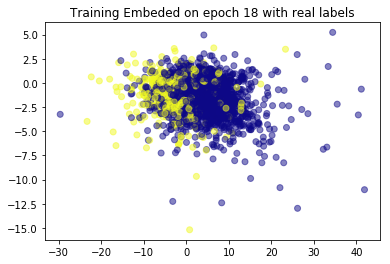

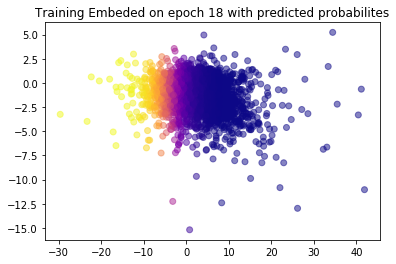


 Current running on: Epoch  19 Training loss:  Average loss 0.3243317796368443


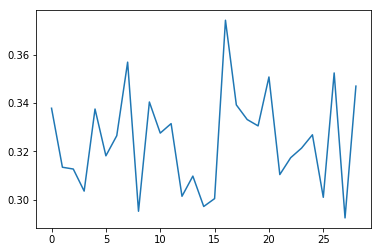

Epoch  19 Summary:  Training_auc : 0.7967685548023677  , Validation_auc :  0.7707423199006387  ,Test_auc :  0.8072984384488426 Test_auc on short visits: 0.8182781902378982 Test_auc on long visits: 0.808240285882797  Avg Loss:  0.3243317796368443 Train Time (0m 51s) Eval Time (0m 31s)


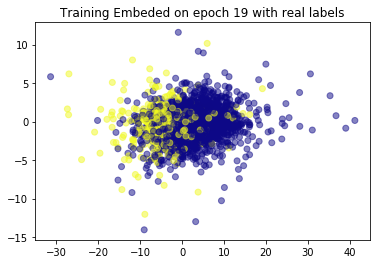

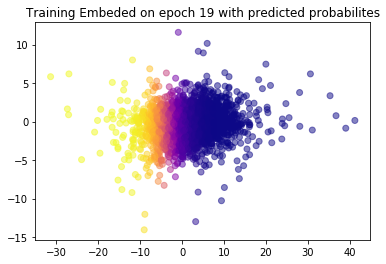

In [9]:
# train, validation, and test for each epoch 
for ep in range(args.epochs):
    start = time.time()
    current_loss, train_loss, em = TVT.train(train1, model= ehr_model, optimizer = optimizer, batch_size = args.batch_size) #mb=args.mb
    avg_loss = np.mean(train_loss)
    train_time = timeSince(start)
    print ('\n Current running on: Epoch ', ep,'Training loss:',' Average loss', avg_loss)
    #print(train_loss, '\n train loss plot')
    TVT.showPlot(train_loss)
    eval_start = time.time()
    train_auc, y_real, y_hat, emb = TVT.calculate_auc(model= ehr_model, data = train1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' Training auc:', train_auc)
    #TVT.auc_plot(y_real, y_hat)
    valid_auc, _, _, _  = TVT.calculate_auc(model = ehr_model, data = valid1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' validation auc:', valid_auc)
    #TVT.auc_plot(y_real, y_hat)
    test_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test1, which_model = args.which_model, batch_size = args.batch_size)
    shorttest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_sh_L, which_model = args.which_model, batch_size = args.batch_size)
    longtest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_l_L, which_model = args.which_model, batch_size = args.batch_size) 
    #print ('\n Current running on: Epoch ', ep,' test auc:', test_auc)
    #TVT.auc_plot(y_real, y_hat)
    eval_time = timeSince(eval_start)
    print ("Epoch ", ep, "Summary:  Training_auc :", train_auc, " , Validation_auc : ", valid_auc, " ,Test_auc : " , test_auc, 
           "Test_auc on short visits:",shorttest_auc, "Test_auc on long visits:", longtest_auc," Avg Loss: ", avg_loss, 'Train Time (%s) Eval Time (%s)'%(train_time,eval_time) )
    current_loss_allep.append(current_loss)
    all_losses_allep.append(train_loss)
    avg_losses_allep.append(avg_loss)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)
    test_sh_auc_allep.append(shorttest_auc)
    test_l_auc_allep.append(longtest_auc)
  
    color1 = np.array([item for item in y_real])
    plt.figure()
    plt.scatter(emb[1:,0],emb[1:,1], c= color1, cmap= 'plasma', alpha = 0.5)
    plt.title('Training Embeded on epoch '+str(ep)+' with real labels')
    plt.show()
    color2 = np.array([item for item in y_hat])
    plt.scatter(emb[1:,0],emb[1:,1], c= color2, cmap='plasma', alpha = 0.5)
    plt.title('Training Embeded on epoch '+str(ep)+' with predicted probabilites')
    plt.show()

In [10]:
# average losses, training auc, validation auc and test auc with epochs
"""
TVT.showPlot(avg_losses_allep)
TVT.showPlot(train_auc_allep)
TVT.showPlot(valid_auc_allep)
TVT.showPlot(test_auc_allep)
"""

'\nTVT.showPlot(avg_losses_allep)\nTVT.showPlot(train_auc_allep)\nTVT.showPlot(valid_auc_allep)\nTVT.showPlot(test_auc_allep)\n'

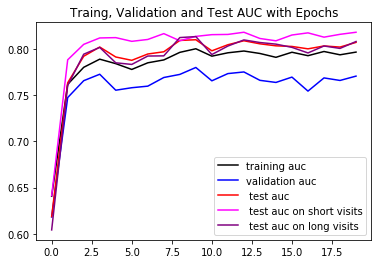

In [11]:
#plot all three auc in a same plot 
plt.plot(train_auc_allep, color= 'black', label = 'training auc')
plt.plot(valid_auc_allep, color ='blue', label = 'validation auc')
plt.plot(test_auc_allep, color = 'red', label =' test auc')
plt.plot(test_sh_auc_allep, color = 'magenta', label =' test auc on short visits')
plt.plot(test_l_auc_allep, color = 'purple', label =' test auc on long visits')
plt.title('Traing, Validation and Test AUC with Epochs' )
plt.legend(loc= 'lower right')
plt.show()

In [15]:
import plotly.plotly as py 
import plotly.graph_objs as go
py.sign_in('GinnyJZ','xJj3WJ9XiB3ijm4frOXc') #get my own sign in please

train_auc_fg= go.Scatter(x= np.arange(args.epochs), y=train_auc_allep, name ='Training auc')
valid_auc_fg= go.Scatter(x= np.arange(args.epochs), y=valid_auc_allep, name ='Validation auc')
test_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_auc_allep, name ='Test auc')
test_sh_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_sh_auc_allep, name ='Test auc on <5 visits)')
test_l_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_l_auc_allep, name ='Test auc on >=5 visits)')

valid_max = max(valid_auc_allep)
test_max = max(test_auc_allep)

data = [train_auc_fg, valid_auc_fg, test_auc_fg, test_sh_auc_fg, test_l_auc_fg]#,valid_auc_allep,test_auc_allep] 
layout = go.Layout(showlegend= True, xaxis=dict(dtick=1))
layout.update(dict(annotations=[go.Annotation(text="Max Valid", x=valid_auc_allep.index(valid_max), y=valid_max)]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='LR_Auc_longshort_dim2')
#url = py.plot(data, filename='some-data')  # gen. online plot
#py.image.save_as(data, 'some-data.png')

Plotly is not rendered on github.The interactive plot is available at **<https://plot.ly/~GinnyJZ/14/training-auc-validation-auc-test-auc-test-auc-on-5-visits/>**

Or you can see a static plot here:

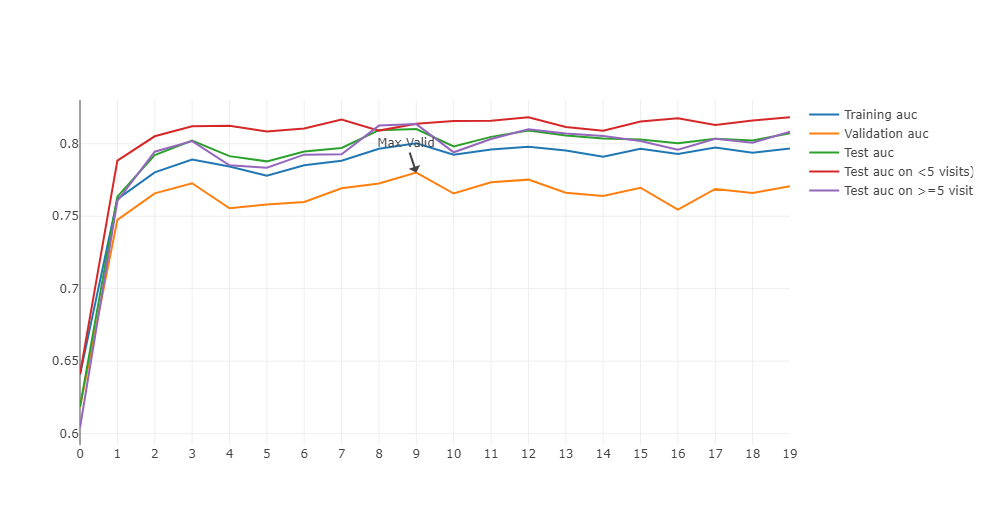

In [2]:
from IPython.display import Image
Image('img/LR_Auc_longshort_dim2.png')

In [13]:
#this block is to explore the embedding matrix vs. types. labels
emb_types = pickle.load(open('Data/h143.types', 'rb'),encoding='bytes')
print(type(emb_types)) #dictionary 
print(len(emb_types)) # it is 20000

<class 'dict'>
15815
